In [1]:
# Stdlib packages
import copy
import datetime
import glob
import json
import os
import re
from pathlib import Path

# Common Py packages
import numpy as np
from matplotlib import pyplot as plt
from prettytable import PrettyTable

# HEP packages
import gpustat
import hist
import mplhep as hep
from cycler import cycler

# ML packages
import torch
import torch.nn as nn
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader

# Module packages
from AMSGrad import AMSGrad
from data_processing import process_data, data_list_index_map
from evaluate import evaluate
from InclusiveNetwork import InclusiveNetwork
from ParticleHLF import ParticleHLF
from space_optimization import optimize_hyperparams
from train import train

gpustat.print_gpustat()
print(torch.cuda.is_available())

plt.style.use(hep.style.CMS)
plt.rcParams.update({'font.size': 20})
cmap_petroff10 = ["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6", "#a96b59", "#e76300", "#b9ac70", "#717581", "#92dadd"]
plt.rcParams.update({"axes.prop_cycle": cycler("color", cmap_petroff10)})

cmslpcgpu3.fnal.gov      Tue Oct  1 21:09:45 2024  555.42.06
[0] Tesla P100-PCIE-12GB | 43°C,   0 % |   748 / 12288 MB | tsievert(746M)
True


In [2]:
lpc_fileprefix = "/eos/uscms/store/group/lpcdihiggsboost/tsievert/HiggsDNA_parquet/v1"

V2_MERGED = True

SIGNAL_FILEPATHS = [
    # Test sig files #
    # '/uscms/home/tsievert/nobackup/XHYbbgg/HiggsDNA_official/output_test_HH/Run3_2022preEE/GluGluToHH/nominal/*',
    # '/uscms/home/tsievert/nobackup/XHYbbgg/HiggsDNA_official/output_test_HH/Run3_2022preEE_merged_v2/GluGluToHH/nominal/*',
    # ggF HH # 
    lpc_fileprefix+f"/Run3_2022preEE_merged{'_v2' if V2_MERGED else ''}/GluGluToHH/nominal/*", lpc_fileprefix+f"/Run3_2022postEE_merged{'_v2' if V2_MERGED else ''}/GluGluToHH/nominal/*",
    # VBF HH #
    # lpc_fileprefix+f"/Run3_2022preEE_merged{'_v2' if V2_MERGED else ''}/VBFHHto2B2G_CV_1_C2V_1_C3_1/nominal/*", lpc_fileprefix+f"/Run3_2022postEE_merged{'_v2' if V2_MERGED else ''}/VBFHHto2B2G_CV_1_C2V_1_C3_1/nominal/*",
]
BKG_FILEPATHS = [
    # ttH (i.e. the main bkg to reduce) #
    lpc_fileprefix+f"/Run3_2022preEE_merged{'_v2' if V2_MERGED else ''}/ttHToGG/nominal/*", lpc_fileprefix+f"/Run3_2022postEE_merged{'_v2' if V2_MERGED else ''}/ttHToGG/nominal/*",
    # # Other single H samples #
    # lpc_fileprefix+f"/Run3_2022preEE_merged{'_v2' if V2_MERGED else ''}/GluGluHToGG/nominal/*", lpc_fileprefix+f"/Run3_2022postEE_merged{'_v2' if V2_MERGED else ''}/GluGluHToGG/nominal/*",
    # lpc_fileprefix+f"/Run3_2022preEE_merged{'_v2' if V2_MERGED else ''}/VBFHToGG/nominal/*", lpc_fileprefix+f"/Run3_2022postEE_merged{'_v2' if V2_MERGED else ''}/VBFHToGG/nominal/*",
    # lpc_fileprefix+f"/Run3_2022preEE_merged{'_v2' if V2_MERGED else ''}/VHToGG/nominal/*", lpc_fileprefix+f"/Run3_2022postEE_merged{'_v2' if V2_MERGED else ''}/VHToGG/nominal/*",
    # # Prompt-Prompt samples #
    # lpc_fileprefix+f"/Run3_2022preEE_merged{'_v2' if V2_MERGED else ''}/GGJets/nominal/*", lpc_fileprefix+f"/Run3_2022postEE_merged{'_v2' if V2_MERGED else ''}/GGJets/nominal/*",
    # # Prompt-Fake samples #
    # lpc_fileprefix+f"/Run3_2022preEE_merged{'_v2' if V2_MERGED else ''}/GJetPt20To40/nominal/*", lpc_fileprefix+f"/Run3_2022postEE_merged{'_v2' if V2_MERGED else ''}/GJetPt20To40/nominal/*",
    # lpc_fileprefix+f"/Run3_2022preEE_merged{'_v2' if V2_MERGED else ''}/GJetPt40/nominal/*", lpc_fileprefix+f"/Run3_2022postEE_merged{'_v2' if V2_MERGED else ''}/GJetPt40/nominal/*",
    # Fake-Fake samples #
    # ADD HERE #
]


CURRENT_DIRPATH = str(Path().absolute())
VERSION = 'v4'
CRITERION = "NLLLoss"
N_PARTICLES, N_PARTICLE_FIELDS = 4, 6
MOD_VALS = (2, 2)
# VARS = 'base_vars'
VARS = 'extra_vars'
CURRENT_TIME = '2024-08-30_14-35-01'
# VARS = 'extra_vars_no_dijet_mass'
# VARS = 'no_bad_vars'
# VARS = 'simplified_bad_vars'
# VARS = 'extra_vars_and_bools'
# VARS = 'extra_vars_in_RNN'
# VARS = f'extra_vars_mod{MOD_VALS[0]}-{MOD_VALS[1]}'
# VARS = 'extra_vars_lead_lep_only'
# CURRENT_TIME = '2024-09-24_20-01-09'
# N_PARTICLES, N_PARTICLE_FIELDS = 3, 6
OUTPUT_DIRPATH = CURRENT_DIRPATH + f"/model_outputs/{VERSION}/{VARS}/"

if not os.path.exists(OUTPUT_DIRPATH):
    os.makedirs(OUTPUT_DIRPATH)

SEED = 21
OPTIMIZE_SPACE = False
NUM_EPOCHS = 150

In [3]:
(
    data_df, data_test_df, 
    data_list, data_hlf, label, 
    data_list_test, data_hlf_test, label_test, 
    high_level_fields, input_hlf_vars, hlf_vars_columns,
    data_aux, data_test_aux
) = process_data(
    N_PARTICLES, N_PARTICLE_FIELDS, SIGNAL_FILEPATHS, BKG_FILEPATHS, OUTPUT_DIRPATH, seed=SEED, return_pre_std=True, mod_vals=MOD_VALS
)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

/uscms/home/tsievert/nobackup/miniconda3/envs/higgs-dna-hhbbgg/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Data list: (258332, 4, 6)
Data HLF: (258332, 14)
n signal = 85041, n bkg = 173291
Data list test: (258924, 4, 6)
Data HLF test: (258924, 14)
n signal = 85713, n bkg = 173211


In [4]:
def plot_train_val_losses(
    IN_info, plot_prefix, plot_postfix='', method='arr', labels=None, sort=None
):
    plt.figure(figsize=(9,7))
    if method == 'std':
        plt.plot(
            range(len(IN_info['train_losses_arr'])), 
            IN_info['train_losses_arr'], label=f"Train data losses", 
            alpha=0.7
        )
        plt.plot(
            range(len(IN_info['train_losses_arr'])), 
            IN_info['val_losses_arr'], label=f"Validation data losses", 
            alpha=0.7
        )
    elif method == 'arr':
        linestyles = ['solid', 'dotted']
        linestyles = linestyles * ((2*len(IN_info['all_preds']) // len(linestyles)) + 1)
        linestyles = linestyles[:2*len(IN_info['all_preds'])]
        for fold_idx in range(skf.get_n_splits()):
            plt.plot(
                range(len(IN_info['train_losses_arr'][fold_idx])), 
                IN_info['train_losses_arr'][fold_idx], 
                label=f"Train data losses - fold {fold_idx}", alpha=0.5,
                linestyle=linestyles[fold_idx if fold_idx%2 == 0 else fold_idx+1]
            )
            plt.plot(
                range(len(IN_info['train_losses_arr'][fold_idx])), 
                IN_info['val_losses_arr'][fold_idx], 
                label=f"Validation data losses - fold {fold_idx}", alpha=0.5,
                linestyle=linestyles[fold_idx+1 if fold_idx%2 == 0 else fold_idx]
            )
    else:
        raise Exception(f"Must used methods 'std' or 'arr'. You used {method}.")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('EPOCH')
    plt.ylabel('Data Loss')
    plt.savefig(f'{plot_prefix}_train_val_losses{plot_postfix}.pdf', bbox_inches='tight')
    plt.savefig(f'{plot_prefix}_train_val_losses{plot_postfix}.png', bbox_inches='tight')
    plt.close()

def plot_roc(
    IN_info, plot_prefix, plot_postfix='', method='std', 
    labels=None, yscale='linear', run2=True, sort=None, run3=None
):
    run2_sigEff = [.9704, .9498, .9196, .7536, .5777, .3837]
    run2_bkgCont = [.2831, .2114, .1539, .0442, .0158, .0041]
    run2_bkgCont_err = [.0077, .0036, .0011, .0032, .0006, .0001]
    plt.figure(figsize=(9,7))
    if method == 'std':
        plt.plot(
            IN_info['mean_fprs'], IN_info['base_tpr'], 
            label="Run3 NN AUC = %.4f" % (IN_info['mean_area'])
        )
    elif method == 'arr':
        linestyles = ['dashed', 'dotted']
        linestyles = linestyles * ((len(IN_info['all_preds']) // len(linestyles)) + 1)
        linestyles = linestyles[:len(IN_info['all_preds'])]
        for fold_idx in range(skf.get_n_splits()):
            plt.plot(
                IN_info['fprs'][fold_idx], IN_info['base_tpr'],
                label="Run3 NN - fold %d" % (fold_idx), linestyle=linestyles[fold_idx],
                alpha=0.5
            )
        plt.plot(
            IN_info['mean_fprs'], IN_info['base_tpr'], 
            label="Run3 NN AUC = %.4f" % (IN_info['mean_area']),
            alpha=0.8
        )
    elif method == 'IN_arr':
        linestyles = ['solid', 'dashed', 'dotted']
        linestyles = linestyles * ((len(IN_info) // len(linestyles)) + 1)
        linestyles = linestyles[:len(IN_info)]
        if sort is not None:
            index_arr = sort
        else:
            index_arr = range(len(IN_info))
        for i in index_arr:
            plt.plot(
                IN_info[i]['mean_fprs'], IN_info[i]['base_tpr'], 
                label=(labels[i]+', ' if labels is not None else '') + "AUC = %.4f" % (IN_info[i]['mean_area']), 
                linestyle=linestyles[i], alpha=0.5
            )
    else:
        raise Exception(f"Must used methods 'std', 'arr', or 'IN_arr'. You used {method}.")
    if run2:
        plt.errorbar(run2_bkgCont, run2_sigEff, xerr=run2_bkgCont_err, label="Run2 NN AUC (val data) = {}".format(0.9469))
    if run3 is not None:
        plt.plot(
            run3['mean_fprs'], run3['base_tpr'], 
            label="Run3 NN AUC = %.4f" % (run3['mean_area']),
            alpha=0.8
        )
    if yscale is not None:
        plt.yscale(yscale)
    plt.ylim(0.1, 1.1)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('Background contamination')
    plt.ylabel('Signal efficiency')
    plt.savefig(f'{plot_prefix}_roc_curve{plot_postfix}.pdf', bbox_inches='tight')
    plt.savefig(f'{plot_prefix}_roc_curve{plot_postfix}.png', bbox_inches='tight')
    plt.close()

def plot_output_score(
        IN_info, plot_prefix, plot_postfix='', method='arr', labels=None, 
        weights={'sig': None, 'bkg': None}, n_bins=50, all_sig=False, all_bkg=False
    ):
    plt.figure(figsize=(9,7))
    if method == 'std':
        sig_np = np.exp(
            IN_info['mean_pred']
        )[
            np.array(IN_info['mean_label']) == 1,1
        ]
        bkg_np = np.exp(
            IN_info['mean_pred']
        )[
            np.array(IN_info['mean_label']) == 0,1
        ]
        for cut in np.linspace(0, 1, 10, endpoint=False):
            print(f"output score > {cut:.2f}")
            print('='*60)
            print(f"num sig > {cut:.2f} = {len(sig_np[sig_np > cut])}")
            print(f"num bkg > {cut:.2f} = {len(bkg_np[bkg_np > cut])}")
            print('-'*60)
        hist_axis = hist.axis.Regular(n_bins, 0., 1., name='var', growth=False, underflow=False, overflow=False)
        sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig_np, weight=weights['sig'] if weights['sig'] is not None else np.ones_like(sig_np))
        bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg_np, weight=weights['bkg'] if weights['sig'] is not None else np.ones_like(bkg_np))
        hep.histplot(
            [sig_hist, bkg_hist],
            yerr=(True if weights['sig'] is not None else False),
            alpha=0.7, density=(False if weights['sig'] is not None else True), histtype='step',
            label=['HH signal', 'ttH background']
        )
    elif method == 'arr':
        linestyles = ['dashed', 'dotted']
        linestyles = linestyles * ((len(IN_info['all_preds']) // len(linestyles)) + 1)
        linestyles = linestyles[:len(IN_info['all_preds'])]
        for fold_idx in range(skf.get_n_splits()):
            sig_np = np.exp(
                IN_info['all_preds'][fold_idx]
            )[
                np.array(IN_info['all_labels'][fold_idx]) == 1,1
            ]
            bkg_np = np.exp(
                IN_info['all_preds'][fold_idx]
            )[
                np.array(IN_info['all_labels'][fold_idx]) == 0,1
            ]
            hist_axis = hist.axis.Regular(n_bins, 0., 1., name='var', growth=False, underflow=False, overflow=False)
            sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig_np, weight=weights['sig'] if weights['sig'] is not None else np.ones_like(sig_np))
            bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg_np, weight=weights['bkg'] if weights['sig'] is not None else np.ones_like(bkg_np))
            hep.histplot(
                [sig_hist, bkg_hist],
                yerr=(True if weights['sig'] is not None else False),
                alpha=0.5, density=(False if weights['sig'] is not None else True), histtype='step',
                label=[
                    f'{"ggF HH" if not all_sig else "ggF HH + VBF HH"} signal'+(' - '+labels[fold_idx] if labels is not None else ''), 
                    f'{"ttH" if not all_bkg else "all"} background'+(' - '+labels[fold_idx] if labels is not None else '')
                ], linestyle=[linestyles[fold_idx], linestyles[fold_idx]]
            )
        sig_np = np.exp(
            IN_info['mean_pred']
        )[
            np.array(IN_info['mean_label']) == 1,1
        ]
        bkg_np = np.exp(
            IN_info['mean_pred']
        )[
            np.array(IN_info['mean_label']) == 0,1
        ]
        for cut in np.linspace(0, 1, 10, endpoint=False):
            print(f"output score > {cut:.2f}")
            print('='*60)
            print(f"num sig > {cut:.2f} = {len(sig_np[sig_np > cut])}")
            print(f"num bkg > {cut:.2f} = {len(bkg_np[bkg_np > cut])}")
            print('-'*60)
        hist_axis = hist.axis.Regular(n_bins, 0., 1., name='var', growth=False, underflow=False, overflow=False)
        sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig_np, weight=weights['sig'] if weights['sig'] is not None else np.ones_like(sig_np))
        bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg_np, weight=weights['bkg'] if weights['sig'] is not None else np.ones_like(bkg_np))
        hep.histplot(
            [sig_hist, bkg_hist],
            yerr=(True if weights['sig'] is not None else False),
            alpha=1, density=(False if weights['sig'] is not None else True), histtype='step',
            label=[
                f'{"ggF HH" if not all_sig else "ggF HH + VBF HH"} signal', 
                f'{"ttH" if not all_bkg else "all"} background'
            ]
        )
    elif method == 'IN_arr':
        linestyles = ['solid', 'dashed', 'dotted']
        linestyles = linestyles * ((len(IN_info) // len(linestyles)) + 1)
        linestyles = linestyles[:len(IN_info)]
        for i in range(len(IN_info)):
            sig_np = np.exp(
                IN_info[i]['mean_pred']
            )[
                np.array(IN_info[i]['mean_label']) == 1,1
            ]
            bkg_np = np.exp(
                IN_info[i]['mean_pred']
            )[
                np.array(IN_info[i]['mean_label']) == 0,1
            ]
            hist_axis = hist.axis.Regular(n_bins, 0., 1., name='var', growth=False, underflow=False, overflow=False)
            sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig_np, weight=weights[i]['sig'] if weights[i]['sig'] is not None else np.ones_like(sig_np))
            bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg_np, weight=weights[i]['bkg'] if weights[i]['sig'] is not None else np.ones_like(bkg_np))
            hep.histplot(
                [sig_hist, bkg_hist],
                yerr=(True if weights[i]['sig'] is not None else False),
                alpha=0.7, density=(False if weights[i]['sig'] is not None else True), histtype='step',
                label=[
                    'HH signal'+(' - '+labels[i] if labels is not None else ''), 
                    'ttH background'+(' - '+labels[i] if labels is not None else '')
                ], linestyle=[linestyles[i], linestyles[i]]
            )
    else:
        raise Exception(f"Must used methods 'std', 'arr', or 'IN_arr'. You used {method}.")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel("Counts", fontsize=18)
    plt.xlabel("Threshold", fontsize=18)
    plt.savefig(f'{plot_prefix}_model_score_dist{plot_postfix}.pdf', bbox_inches='tight')
    plt.savefig(f'{plot_prefix}_model_score_dist{plot_postfix}.png', bbox_inches='tight')
    plt.close()

def s_over_root_b(
        IN_info, plot_prefix, plot_postfix='', method='arr', labels=None, 
        weights={'sig': None, 'bkg': None}, lines_fold=None, lines=None, lines_labels=None, 
        lines_colors=None, only_fold=None, no_fold=False, n_bins=50
    ):
    plt.figure(figsize=(9,7))
    if method == 'std':
        sig_np = np.exp(
            IN_info['mean_pred']
        )[
            np.array(IN_info['mean_label']) == 1,1
        ]
        bkg_np = np.exp(
            IN_info['mean_pred']
        )[
            np.array(IN_info['mean_label']) == 0,1
        ]
        hist_axis = hist.axis.Regular(n_bins, 0., 1., name='var', growth=False, underflow=False, overflow=False)
        sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig_np, weight=weights['sig'])
        bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg_np, weight=weights['bkg'])
        s_over_root_b_points = sig_hist.values().flatten() / np.sqrt(bkg_hist.values().flatten())
        plt.plot(
            np.arange(0., 1., 1/n_bins), s_over_root_b_points, 
            label='s/√b', alpha=0.8 
        )
    elif method == 'arr':
        linestyles = ['dashed', 'dotted']
        linestyles = linestyles * ((len(IN_info['all_preds']) // len(linestyles)) + 1)
        linestyles = linestyles[:len(IN_info['all_preds'])]
        for fold_idx in range(skf.get_n_splits()):
            if (only_fold is not None and fold_idx != only_fold) or no_fold == True:
                continue
            sig_np = np.exp(
                IN_info['all_preds'][fold_idx]
            )[
                np.array(IN_info['all_labels'][fold_idx]) == 1,1
            ]
            bkg_np = np.exp(
                IN_info['all_preds'][fold_idx]
            )[
                np.array(IN_info['all_labels'][fold_idx]) == 0,1
            ]
            hist_axis = hist.axis.Regular(n_bins, 0., 1., name='var', growth=False, underflow=False, overflow=False)
            sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig_np, weight=weights['sig'])
            bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg_np, weight=weights['bkg'])
            s_over_root_b_points = sig_hist.values().flatten() / np.sqrt(bkg_hist.values().flatten())
            plt.plot(
                np.arange(0., 1., 1/n_bins), s_over_root_b_points, 
                label='s/√b'+(' - fold '+labels[fold_idx] if labels is not None else ''), 
                alpha=0.5, linestyle=linestyles[fold_idx], 
            )
            if lines_fold is not None:
                for i in range(len(lines_fold[fold_idx])):
                    plt.vlines(
                        lines_fold[fold_idx][i], 0, np.max(s_over_root_b_points), 
                        label='s/√b'+(' - '+lines_labels[fold_idx][i] if lines_labels is not None else ''), 
                        alpha=0.5, colors=lines_colors[fold_idx][i]
                    )
        if only_fold is None:
            sig_np = np.exp(
                IN_info['mean_pred']
            )[
                np.array(IN_info['mean_label']) == 1,1
            ]
            bkg_np = np.exp(
                IN_info['mean_pred']
            )[
                np.array(IN_info['mean_label']) == 0,1
            ]
            hist_axis = hist.axis.Regular(n_bins, 0., 1., name='var', growth=False, underflow=False, overflow=False)
            sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig_np, weight=weights['sig'])
            bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg_np, weight=weights['bkg'])
            s_over_root_b_points = sig_hist.values().flatten() / np.sqrt(bkg_hist.values().flatten())
            plt.plot(
                np.arange(0., 1., 1/n_bins), s_over_root_b_points, 
                label='s/√b - avg. over folds', 
                alpha=0.5, 
            )
            if lines is not None:
                for i in range(len(lines)):
                    plt.vlines(
                        lines[i], 0, np.max(s_over_root_b_points), 
                        label='s/√b - avg.'+(' - '+lines_labels[i] if lines_labels is not None else ''), 
                        alpha=0.5, colors=lines_colors[i]
                    )
    elif method == 'IN_arr':
        linestyles = ['solid', 'dashed', 'dotted']
        linestyles = linestyles * ((len(IN_info) // len(linestyles)) + 1)
        linestyles = linestyles[:len(IN_info)]
        for i in range(len(IN_info)):
            sig_np = np.exp(
                IN_info[i]['all_preds'][0]
            )[
                np.array(IN_info[i]['all_labels'][0]) == 1,1
            ]
            bkg_np = np.exp(
                IN_info[i]['all_preds'][0]
            )[
                np.array(IN_info[i]['all_labels'][0]) == 0,1
            ]
            hist_axis = hist.axis.Regular(n_bins, 0., 1., name='var', growth=False, underflow=False, overflow=False)
            sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig_np, weight=weights[i]['sig'])
            bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg_np, weight=weights[i]['bkg'])
            plt.plot(
                np.arange(0., 1., 1/n_bins), sig_hist.values().flatten() / np.sqrt(bkg_hist.values().flatten()), 
                label='s/√b'+(' - '+labels[i] if labels is not None else ''), 
                alpha=0.5, linestyle=linestyles[i], 
            )
    else:
        raise Exception(f"Must used methods 'std', 'arr', or 'IN_arr'. You used {method}.")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel("Counts", fontsize=18)
    plt.xlabel("Threshold", fontsize=18)
    plt.savefig(f'{plot_prefix}_model_s_over_b{plot_postfix}.pdf', bbox_inches='tight')
    plt.savefig(f'{plot_prefix}_model_s_over_b{plot_postfix}.png', bbox_inches='tight')
    plt.close()
    

In [5]:
MC_NAMES_PRETTY = {
    "GGJets": r"$\gamma\gamma+3j$",
    "GJetPt20To40": r"$\gamma+j$, 20<$p_T$<40GeV",
    "GJetPt40": r"$\gamma+j$, 40GeV<$p_T$",
    "GluGluHToGG": r"ggF $H\rightarrow \gamma\gamma$",
    "VBFHToGG": r"VBF $H\rightarrow \gamma\gamma$",
    "VHToGG": r"V$H\rightarrow\gamma\gamma$",
    "ttHToGG": r"$t\bar{t}H\rightarrow\gamma\gamma$",
    "GluGluToHH": r"ggF $HH\rightarrow bb\gamma\gamma$",
    "signal": r"ggF $HH\rightarrow bb\gamma\gamma$ + VBF $HH\rightarrow bb\gamma\gamma$"
    # "VBFHHto2B2G_CV_1_C2V_1_C3_1": r"VBF $HH\rightarrow bb\gamma\gamma$",
    # Need to fill in pretty print for BSM samples #
}
LUMINOSITIES = {
    '2022preEE': 7.9804, 
    '2022postEE': 26.6717,
    # Need to fill in lumis for other eras #
}
LUMINOSITIES['total_lumi'] = sum(LUMINOSITIES.values())

# Dictionary of variables
VARIABLES = {
    # key: hist.axis axes for plotting #
    # MET variables
    'puppiMET_sumEt': hist.axis.Regular(40, 20., 250, name='var', label=r'puppiMET $\Sigma E_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'puppiMET_pt': hist.axis.Regular(40, 20., 250, name='var', label=r'puppiMET $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'puppiMET_phi': hist.axis.Regular(20,-3.2, 3.2, name='var', label=r'puppiMET $\phi$', growth=False, underflow=False, overflow=False), 
    # jet-MET variables
    'DeltaPhi_j1MET': hist.axis.Regular(20,-3.2, 3.2, name='var', label=r'$\Delta\phi (j_1,E_T^{miss})$', growth=False, underflow=False, overflow=False), 
    'DeltaPhi_j2MET': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'$\Delta\phi (j_2,E_T^{miss})$', growth=False, underflow=False, overflow=False), 
    # jet-photon variables
    'DeltaR_jg_min': hist.axis.Regular(30, 0, 5, name='var', label=r'min$(\Delta R(jet, \gamma))$', growth=False, underflow=False, overflow=False), 
    # jet variables
    'jet1_pt': hist.axis.Regular(40, 20., 250, name='var', label=r'lead jet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
    'jet2_pt': hist.axis.Regular(40, 20., 250, name='var', label=r'sublead jet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
    'n_jets': hist.axis.Integer(0, 10, name='var', label=r'$n_{jets}$', growth=False, underflow=False, overflow=False), 
    'chi_t0': hist.axis.Regular(40, 0., 150, name='var', label=r'$\chi_{t0}^2$', growth=False, underflow=False, overflow=False), 
    'chi_t1': hist.axis.Regular(30, 0., 500, name='var', label=r'$\chi_{t1}^2$', growth=False, underflow=False, overflow=False), 
    # lepton variables
    'lepton1_pt': hist.axis.Regular(40, 0., 200., name='var', label=r'lead lepton $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'lepton2_pt': hist.axis.Regular(40, 0., 200., name='var', label=r'sublead lepton $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'lepton1_eta': hist.axis.Regular(30, -5., 5., name='var', label=r'lead lepton $\eta$', growth=False, underflow=False, overflow=False), 
    'lepton2_eta': hist.axis.Regular(30, -5., 5., name='var', label=r'sublead lepton $\eta$', growth=False, underflow=False, overflow=False),
    'lepton1_phi': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'lead lepton $\phi$', growth=False, underflow=False, overflow=False), 
    'lepton2_phi': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'sublead lepton $\phi$', growth=False, underflow=False, overflow=False),
    # diphoton variables
    'pt': hist.axis.Regular(40, 20., 2000, name='var', label=r' $\gamma\gamma p_{T}$ [GeV]', growth=False, underflow=False, overflow=False),
    'eta': hist.axis.Regular(20, -5., 5., name='var', label=r'$\gamma\gamma \eta$', growth=False, underflow=False, overflow=False), 
    'phi': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'$\gamma \gamma \phi$', growth=False, underflow=False, overflow=False),
    # angular (cos) variables
    'abs_CosThetaStar_CS': hist.axis.Regular(20, 0, 1, name='var', label=r'|cos$(\theta_{CS})$|', growth=False, underflow=False, overflow=False), 
    'abs_CosThetaStar_jj': hist.axis.Regular(20, 0, 1, name='var', label=r'|cos$(\theta_{jj})$|', growth=False, underflow=False, overflow=False),
    'CosThetaStar_CS': hist.axis.Regular(20, -1, 1, name='var', label=r'cos$(\theta_{CS})$', growth=False, underflow=False, overflow=False), 
    'CosThetaStar_jj': hist.axis.Regular(20, -1, 1, name='var', label=r'cos$(\theta_{jj})$', growth=False, underflow=False, overflow=False), 
    # jet-lepton variables
    'leadBjet_leadLepton': hist.axis.Regular(30, 0, 5, name='var', label=r'$\Delta R(bjet_{lead}, l_{lead})$', growth=False, underflow=False, overflow=False), 
    'leadBjet_subleadLepton': hist.axis.Regular(30, 0, 5, name='var', label=r'$\Delta R(bjet_{lead}, l_{sublead})$', growth=False, underflow=False, overflow=False), 
    'subleadBjet_leadLepton': hist.axis.Regular(30, 0, 5, name='var', label=r'$\Delta R(bjet_{sublead}, l_{lead})$', growth=False, underflow=False, overflow=False), 
    'subleadBjet_subleadLepton': hist.axis.Regular(30, 0, 5, name='var', label=r'$\Delta R(bjet_{sublead}, l_{sublead})$', growth=False, underflow=False, overflow=False),
    # dijet variables (must be blinded on data)
    'dijet_mass': hist.axis.Regular(50, 25., 180., name='var', label=r'$M_{jj}$ [GeV]', growth=False, underflow=False, overflow=False),
    # diphoton variables (must be blinded on data)
    'mass': hist.axis.Regular(50, 25., 180., name='var', label=r'$M_{\gamma\gamma}$ [GeV]', growth=False, underflow=False, overflow=False),
}
# Dictionary of variables to do MC/Data comparison
VARIABLES_STD = {
    # key: hist.axis axes for plotting #
    # MET variables
    'puppiMET_sumEt': hist.axis.Regular(40, -4., 4., name='var', label=r'puppiMET $\Sigma E_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'puppiMET_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'puppiMET $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'puppiMET_phi': hist.axis.Regular(40, -4., 4., name='var', label=r'puppiMET $\phi$', growth=False, underflow=False, overflow=False), 
    # jet-MET variables
    'DeltaPhi_j1MET': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta\phi (j_1,E_T^{miss})$', growth=False, underflow=False, overflow=False), 
    'DeltaPhi_j2MET': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta\phi (j_2,E_T^{miss})$', growth=False, underflow=False, overflow=False), 
    # jet-photon variables
    'DeltaR_jg_min': hist.axis.Regular(40, -4., 4., name='var', label=r'min$(\Delta R(jet, \gamma))$', growth=False, underflow=False, overflow=False), 
    # jet variables
    'jet1_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'lead jet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
    'jet2_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead jet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
    'n_jets': hist.axis.Regular(12, -4., 4., name='var', label=r'$n_{jets}$', growth=False, underflow=False, overflow=False), 
    'chi_t0': hist.axis.Regular(40, -10., 4., name='var', label=r'$\chi_{t0}^2$', growth=False, underflow=False, overflow=False), 
    'chi_t1': hist.axis.Regular(40, -10., 4., name='var', label=r'$\chi_{t1}^2$', growth=False, underflow=False, overflow=False), 
    # lepton variables
    'lepton1_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'lead lepton $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'lepton2_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead lepton $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'lepton1_eta': hist.axis.Regular(40, -4., 4., name='var', label=r'lead lepton $\eta$', growth=False, underflow=False, overflow=False), 
    'lepton2_eta': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead lepton $\eta$', growth=False, underflow=False, overflow=False),
    'lepton1_phi': hist.axis.Regular(40, -4., 4., name='var', label=r'lead lepton $\phi$', growth=False, underflow=False, overflow=False), 
    'lepton2_phi': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead lepton $\phi$', growth=False, underflow=False, overflow=False),
    # diphoton variables
    'pt': hist.axis.Regular(40, -4., 4., name='var', label=r' $\gamma\gamma p_{T}$ [GeV]', growth=False, underflow=False, overflow=False),
    'eta': hist.axis.Regular(40, -4., 4., name='var', label=r'$\gamma\gamma \eta$', growth=False, underflow=False, overflow=False), 
    'phi': hist.axis.Regular(40, -4., 4., name='var', label=r'$\gamma \gamma \phi$', growth=False, underflow=False, overflow=False),
    # angular (cos) variables
    'abs_CosThetaStar_CS': hist.axis.Regular(40, -4., 4., name='var', label=r'|cos$(\theta_{CS})$|', growth=False, underflow=False, overflow=False), 
    'abs_CosThetaStar_jj': hist.axis.Regular(40, -4., 4., name='var', label=r'|cos$(\theta_{jj})$|', growth=False, underflow=False, overflow=False), 
    'CosThetaStar_CS': hist.axis.Regular(40, -1., 1., name='var', label=r'cos$(\theta_{CS})$', growth=False, underflow=False, overflow=False), 
    'CosThetaStar_jj': hist.axis.Regular(40, -1., 1., name='var', label=r'cos$(\theta_{jj})$', growth=False, underflow=False, overflow=False), 
    # jet-lepton variables
    'leadBjet_leadLepton': hist.axis.Regular(40, -10., 4., name='var', label=r'$\Delta R(bjet_{lead}, l_{lead})$', growth=False, underflow=False, overflow=False), 
    'leadBjet_subleadLepton': hist.axis.Regular(40, -10., 4., name='var', label=r'$\Delta R(bjet_{lead}, l_{sublead})$', growth=False, underflow=False, overflow=False), 
    'subleadBjet_leadLepton': hist.axis.Regular(40, -10., 4., name='var', label=r'$\Delta R(bjet_{sublead}, l_{lead})$', growth=False, underflow=False, overflow=False), 
    'subleadBjet_subleadLepton': hist.axis.Regular(40, -10., 4., name='var', label=r'$\Delta R(bjet_{sublead}, l_{sublead})$', growth=False, underflow=False, overflow=False),
    # dijet variables (must be blinded on data)
    'dijet_mass': hist.axis.Regular(40, -4., 4., name='var', label=r'$M_{jj}$ [GeV]', growth=False, underflow=False, overflow=False),
    # diphoton variables (must be blinded on data)
    'mass': hist.axis.Regular(40, -4., 4., name='var', label=r'$M_{\gamma\gamma}$ [GeV]', growth=False, underflow=False, overflow=False),
}

def post_std_np_arrays(
        data, data_test, var_name, train_index=None, val_index=None
):
    sig_mask = label == 1
    sig_test_mask = label_test == 1
    bkg_mask = label == 0
    bkg_test_mask = label_test == 0
    if train_index is not None and val_index is not None:
        sig_train_mask = sig_mask & train_index 
        sig_val_mask = sig_mask & val_index
        bkg_train_mask = bkg_mask & train_index
        bkg_val_mask = bkg_mask & val_index
        if var_name in (high_level_fields - set(input_hlf_vars)):
            sig_train_np = data[data_list_index_map(var_name, data, sig_train_mask)]
            sig_val_np = data[data_list_index_map(var_name, data, sig_val_mask)]
            sig_test_np = data_test[data_list_index_map(var_name, data_test, sig_test_mask)]
            bkg_train_np = data[data_list_index_map(var_name, data, sig_train_mask)]
            bkg_val_np = data[data_list_index_map(var_name, data, bkg_val_mask)]
            bkg_test_np = data_test[data_list_index_map(var_name, data_test, bkg_test_mask)]
        else:
            index2 = hlf_vars_columns[var_name]
            sig_train_np = data[sig_train_mask, index2]
            sig_val_np = data[sig_val_mask, index2]
            sig_test_np = data_test[sig_test_mask, index2]
            bkg_train_np = data[bkg_train_mask, index2]
            bkg_val_np = data[bkg_val_mask, index2]
            bkg_test_np = data_test[bkg_test_mask, index2]

        return (
            sig_train_np, sig_val_np, sig_test_np, 
            bkg_train_np, bkg_val_np, bkg_test_np
        )
    elif train_index is None and val_index is None:
        if var_name in (high_level_fields - set(input_hlf_vars)):
            # index2, index3 = index_map[var_name]
            sig_train_np = data[data_list_index_map(var_name, data, sig_mask)]
            sig_test_np = data_test[data_list_index_map(var_name, data_test, sig_test_mask)]
            bkg_train_np = data[data_list_index_map(var_name, data, bkg_mask)]
            bkg_test_np = data_test[data_list_index_map(var_name, data_test, bkg_test_mask)]
        else:
            index2 = hlf_vars_columns[var_name]
            sig_train_np = data[sig_mask, index2]
            sig_test_np = data_test[sig_test_mask, index2]
            bkg_train_np = data[bkg_mask, index2]
            bkg_test_np = data_test[bkg_test_mask, index2]
        return (
            copy.deepcopy(sig_train_np), copy.deepcopy(sig_test_np), 
            copy.deepcopy(bkg_train_np), copy.deepcopy(bkg_test_np)
        )
    else:
        raise Exception("Either both train_index and val_index must be 'None', or both should not be 'None'. You cannot mix and match.")

def aux_np_arrays(var_name, score_cut, IN_full_eval_dict):
    sig_train_mask = (label == 1) & (
        np.exp(IN_full_eval_dict['train']['mean_pred'])[:, 1] > score_cut
    )
    sig_test_mask = (label_test == 1) & (
        np.exp(IN_full_eval_dict['test']['mean_pred'])[:, 1] > score_cut
    )
    bkg_train_mask = (label == 0) & (
        np.exp(IN_full_eval_dict['train']['mean_pred'])[:, 1] > score_cut
    )
    bkg_test_mask = (label_test == 0) & (
        np.exp(IN_full_eval_dict['test']['mean_pred'])[:, 1] > score_cut
    )

    sig_train_np = data_aux.loc[sig_train_mask, var_name].to_numpy()
    sig_test_np = data_test_aux.loc[sig_test_mask, var_name].to_numpy()
    bkg_train_np = data_aux.loc[bkg_train_mask, var_name].to_numpy()
    bkg_test_np = data_test_aux.loc[bkg_test_mask, var_name].to_numpy()

    return (
        copy.deepcopy(sig_train_np), copy.deepcopy(sig_test_np), 
        copy.deepcopy(bkg_train_np), copy.deepcopy(bkg_test_np)
    )

def make_input_plot(
    output_dir, var_name, hist_list, fold_idx=None, labels=None, density=True, 
    plot_prefix='', plot_postfix='', alpha=0.8, linestyle=True
):
    fig, ax = plt.subplots()
    if linestyle:
        if fold_idx is not None:
            linestyles = ["solid", "dashed", "dotted", "solid", "dashed", "dotted"]
        else:
            linestyles = ["solid", "dotted", "solid", "dotted"]
        linestyles = linestyles * ((len(hist_list) // len(linestyles)) + 1)
        linestyles = linestyles[:len(hist_list)]
    else:
        linestyles = None
    hep.histplot(
        hist_list, ax=ax, linewidth=3, histtype="step", yerr=True, density=density,
        linestyle=linestyles, label=labels, alpha=alpha
    )
    # Plotting niceties #
    hep.cms.lumitext(f"{LUMINOSITIES['total_lumi']:.2f}" + r"fb$^{-1}$ (13.6 TeV)", ax=ax)
    hep.cms.text("Work in Progress", ax=ax)
    # Plot legend properly
    ax.legend(bbox_to_anchor=(1, 0.5))
    # Make angular and chi^2 plots linear, otherwise log
    if re.match('chi_t', var_name) is None and re.match('DeltaPhi', var_name) is None and re.match('mass', var_name) is None:
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
    ax.set_yscale('linear')
    # Save out the plot
    if fold_idx is not None:
        output_dir = output_dir + "fold/"
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        plt.savefig(f'{output_dir}/{plot_prefix}1dhist_{var_name}{plot_postfix}_fold{fold_idx}.pdf', bbox_inches='tight')
        plt.savefig(f'{output_dir}/{plot_prefix}1dhist_{var_name}{plot_postfix}_fold{fold_idx}.png', bbox_inches='tight')
    else:
        plt.savefig(f'{output_dir}/{plot_prefix}1dhist_{var_name}{plot_postfix}.pdf', bbox_inches='tight')
        plt.savefig(f'{output_dir}/{plot_prefix}1dhist_{var_name}{plot_postfix}.png', bbox_inches='tight')
    plt.close()

def plot_input_vars_after_score_cut(
    IN_info, score_cut, destdir, plot_prefix, plot_postfix='', method='std', 
    weights={'sig': None, 'bkg': None}, all_sig=False, all_bkg=False
):
    if method == 'std':
        sig_mask = np.exp(
            IN_info['mean_pred']
        )[
            np.array(IN_info['mean_label']) == 1,1
        ] > score_cut
        bkg_mask = np.exp(
            IN_info['mean_pred']
        )[
            np.array(IN_info['mean_label']) == 0,1
        ] > score_cut

        for var_name in high_level_fields:
            if var_name in {'event', 'puppiMET_eta'}:
                continue
            sig_var = data_test_df.loc[label_test==1, var_name]
            sig_hist = hist.Hist(VARIABLES[var_name]).fill(
                var=sig_var.loc[sig_mask], 
                weight=weights['sig'][sig_mask] if weights['sig'] is not None else np.ones(np.sum(sig_mask))
            )
            bkg_var = data_test_df.loc[label_test==0, var_name]
            bkg_hist = hist.Hist(VARIABLES[var_name]).fill(
                var=bkg_var.loc[bkg_mask], 
                weight=weights['bkg'][bkg_mask] if weights['bkg'] is not None else np.ones(np.sum(bkg_mask))
            )
            make_input_plot(
                destdir, var_name, [sig_hist, bkg_hist], plot_prefix=plot_prefix, 
                plot_postfix=plot_postfix+f'_ttHscore{score_cut}', labels=['HH signal', 'ttH background'], density=False if weights['sig'] is not None else True
            )
    elif method == 'arr':
        for var_name in high_level_fields:
            if var_name in {'event', 'puppiMET_eta'}:
                continue
            sig_var = data_test_df.loc[label_test==1, var_name]
            bkg_var = data_test_df.loc[label_test==0, var_name]
            sig_masks, bkg_masks = [], []
            hists, labels = [], []
            for cut in score_cut:
                sig_masks.append(np.exp(
                    IN_info['mean_pred']
                )[
                    np.array(IN_info['mean_label']) == 1,1
                ] > cut)
                bkg_masks.append(np.exp(
                    IN_info['mean_pred']
                )[
                    np.array(IN_info['mean_label']) == 0,1
                ] > cut)
                
                hists.append(hist.Hist(VARIABLES[var_name]).fill(
                    var=sig_var.loc[sig_masks[-1]], 
                    weight=weights['sig'][sig_masks[-1]] if weights['sig'] is not None else np.ones(np.sum(sig_masks[-1]))
                ))
                hists.append(hist.Hist(VARIABLES[var_name]).fill(
                    var=bkg_var.loc[bkg_masks[-1]], 
                    weight=weights['bkg'][bkg_masks[-1]] if weights['bkg'] is not None else np.ones(np.sum(bkg_masks[-1]))
                ))
                labels.extend([f'HH signal, ttH-score > {cut}', f'ttH background, ttH-score > {cut}'])
            make_input_plot(
                destdir, var_name, hists, plot_prefix=plot_prefix, 
                plot_postfix=plot_postfix+f'_ttHscore_scan', labels=labels, density=False if weights['sig'] is not None else True
            )
    else:
        raise Exception(f"Must used method 'std'. You used {method}.")

### Run the optimization

In [6]:
CURRENT_TIME = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

if CRITERION == "NLLLoss":
    train_weights = torch.FloatTensor(
        [1.0, np.sum(data_aux.loc[label==0,'eventWeight']) / np.sum(data_aux.loc[label==1,'eventWeight'])]
    ).cuda()
    criterion = nn.NLLLoss(weight=train_weights)
elif CRITERION == "BCELoss":
    train_weights = torch.FloatTensor(data_aux.loc[:, "eventWeight"]).cuda()
    criterion = nn.BCELoss(weight=train_weights)
else:
    raise Exception(f"CRITERION must be either 'NLLLoss' or 'BCELoss'. You provided {CRITERION}.")

if OPTIMIZE_SPACE:
    config_file = OUTPUT_DIRPATH + CURRENT_TIME + '_BestConfigReallyTopclass.json'
    best_conf = optimize_hyperparams(
        skf, data_list, data_hlf, label, 
        config_file, epochs=10,
        criterion=criterion
    )
    print(best_conf)
else:
    # with open(OUTPUT_DIRPATH + CURRENT_TIME + '_BestConfigReallyTopclass.json') as f:
    # with open('model_outputs/v0/BestConfigReallyTopclass.json', 'r') as f:
    with open('/uscms/home/tsievert/nobackup/XHYbbgg/HHtobbyy/model_outputs/v4/extra_vars/2024-08-20_23-02-48_BestConfigReallyTopclass.json') as f:
        best_conf = json.load(f)
        print(best_conf)

fom = []
train_losses_arr, val_losses_arr = [], []
for fold_idx, (train_index, val_index) in enumerate(skf.split(data_hlf, label)):
    model_file = OUTPUT_DIRPATH + CURRENT_TIME +'_ReallyTopclassStyle_'+ f'{fold_idx}.torch'
    state_file = OUTPUT_DIRPATH + CURRENT_TIME +'_BestPerfReallyTopclass_'+ f'{fold_idx}.torch'

    if CRITERION == "NLLLoss":
        rectified_train_index = np.ones(len(label), dtype=bool)
        rectified_train_index[val_index] = False
        sig_train_mask = rectified_train_index & (label == 1)
        bkg_train_mask = rectified_train_index & (label == 0)
        train_weights = torch.FloatTensor(
            [1.0, np.sum(data_aux.loc[bkg_train_mask,'eventWeight']) / np.sum(data_aux.loc[sig_train_mask,'eventWeight'])]
        ).cuda()
        criterion = nn.NLLLoss(weight=train_weights)
    elif CRITERION == "BCELoss":
        train_weights = torch.FloatTensor((data_aux.iloc[train_index]).loc[:, "eventWeight"]).cuda()
        criterion = nn.BCELoss(weight=train_weights)
        
    model = InclusiveNetwork(
        best_conf['hidden_layers'], best_conf['initial_nodes'], best_conf['dropout'], 
        best_conf['gru_layers'], best_conf['gru_size'], best_conf['dropout_g'], 
        dnn_input=np.shape(data_hlf)[-1], rnn_input=np.shape(data_list)[-1]
    ).cuda()
    optimizer = AMSGrad(model.parameters(), lr=best_conf['learning_rate'], weight_decay=best_conf['L2_reg'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    
    train_loader = DataLoader(
        ParticleHLF(data_list[train_index], data_hlf[train_index], label[train_index]), 
        batch_size=best_conf['batch_size'], shuffle=True
    )
    val_loader = DataLoader(
        ParticleHLF(data_list[val_index], data_hlf[val_index], label[val_index]), 
        batch_size=best_conf['batch_size'], shuffle=True
    )
    data_loader = {"training": train_loader, "validation": val_loader} 

    best_acc, train_losses, val_losses = train(
        NUM_EPOCHS, model, criterion, optimizer, scheduler, 
        state_file, model_file, data_loader=data_loader
    )
    train_losses_arr.append(train_losses)
    val_losses_arr.append(val_losses)

    fom.append(best_acc)

Y = np.mean(np.asarray([acc.cpu() for acc in fom]))
print("Average best_acc across k-fold: {}".format(Y))
model = InclusiveNetwork(
    best_conf['hidden_layers'], best_conf['initial_nodes'], best_conf['dropout'], 
    best_conf['gru_layers'], best_conf['gru_size'], best_conf['dropout_g']
).cuda()

{'hidden_layers': 2, 'initial_nodes': 500, 'dropout': 0.27817607062770483, 'gru_layers': 2, 'gru_size': 500, 'dropout_g': 0.6184468141076988, 'learning_rate': 0.004851812500501461, 'batch_size': 4000, 'L2_reg': 0.0001}


/uscms_data/d3/tsievert/XHYbbgg/HHtobbyy/AMSGrad.py:86: UserWarning: This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha) (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1706619781071/work/torch/csrc/utils/python_arg_parser.cpp:1519.)
  grad = grad.add(group['weight_decay'], p.data)


Early stopped.
Best val acc: 77.397942
----------
Early stopped.
Best val acc: 80.067062
----------
Early stopped.
Best val acc: 75.281052
----------
Early stopped.
Best val acc: 76.687927
----------
Early stopped.
Best val acc: 77.194138
----------
Average best_acc across k-fold: 77.32562255859375


### Performance on test set

In [6]:
print(data_test_df['lepton1_pt'])
print(data_list_test[:10])

0        -999.0
1        -999.0
2        -999.0
3        -999.0
4        -999.0
          ...  
164363   -999.0
164364   -999.0
164365   -999.0
164366   -999.0
164367   -999.0
Name: lepton1_pt, Length: 164368, dtype: float64
[[[ 0.84494881 -1.16565029 -0.68858366  0.          1.
    0.        ]
  [ 0.48266669  0.          2.02001953  0.          0.
    1.        ]
  [ 0.          0.          0.          1.          0.
    0.        ]]

 [[ 0.11602272 -0.31216671 -3.09989393  0.          1.
    0.        ]
  [-0.06000286  0.         -2.47167969  0.          0.
    1.        ]
  [ 0.          0.          0.          1.          0.
    0.        ]]

 [[-0.42883682  0.          0.73364258  0.          0.
    1.        ]
  [-0.73420357 -0.64723517  0.72110644  0.          1.
    0.        ]
  [ 0.          0.          0.          1.          0.
    0.        ]]

 [[ 0.91901461  0.13413224 -1.67067568  0.          1.
    0.        ]
  [-1.70953849  0.          2.24023438  0.          0.
    

In [6]:
# with open('model_outputs/v0/BestConfigReallyTopclass.json', 'r') as f:
# with open(OUTPUT_DIRPATH + CURRENT_TIME + '_BestConfigReallyTopclass.json') as f:
with open('/uscms/home/tsievert/nobackup/XHYbbgg/HHtobbyy/model_outputs/v4/extra_vars/2024-08-20_23-02-48_BestConfigReallyTopclass.json') as f:
    best_conf = json.load(f)
try:
    IN_perf = evaluate(
        data_list_test, data_hlf_test, label_test, 
        OUTPUT_DIRPATH, CURRENT_TIME, skf, best_conf, 
        train_losses_arr=train_losses_arr, val_losses_arr=val_losses_arr, 
        # save=True
    )
except:
    IN_perf = evaluate(
        data_list_test, data_hlf_test, label_test, 
        OUTPUT_DIRPATH, CURRENT_TIME, skf, best_conf, 
        # save=True
    )

------------------------------------------------------------
[1. 1. 0. ... 1. 1. 0.]
[0.9970413  0.50865428 0.58346946 ... 0.89538741 0.96870785 0.43477409]
------------------------------------------------------------
[1. 1. 0. ... 1. 1. 0.]
[0.99695516 0.57272134 0.72251761 ... 0.87728638 0.96046223 0.45102384]
------------------------------------------------------------
[1. 1. 0. ... 1. 1. 0.]
[0.99768235 0.66128387 0.7471156  ... 0.91467033 0.97058501 0.38047227]
------------------------------------------------------------
[1. 1. 0. ... 1. 1. 0.]
[0.99807004 0.66378814 0.66590999 ... 0.93583847 0.97769712 0.37436685]
------------------------------------------------------------
[1. 1. 0. ... 1. 1. 0.]
[0.99754331 0.59889301 0.86107738 ... 0.89176161 0.97538335 0.55379372]
[[           inf 9.99950224e-01 9.99942526e-01 ... 3.85228293e-02
  2.20779765e-02 7.98942379e-05]
 [           inf 9.99950079e-01 9.99939614e-01 ... 3.59063739e-02
  2.21875446e-02 2.09104226e-05]
 [           inf 

In [10]:
print(np.shape(IN_perf['all_preds']))
print(np.shape(data_test_df['lepton1_pt'] == -999))

slice_arr_0leps = np.array(data_test_df['lepton1_pt'] == -999, dtype=int)
preds_0leps = np.where(slice_arr_0leps == 1, np.exp(IN_perf['mean_pred'])[:,1], -999)
preds_0leps = preds_0leps[preds_0leps != -999]
print(f"0 leptons avg. predictions: {preds_0leps}")
print(f"0 leptons mean avg. prediction: {np.mean(preds_0leps)}")
print('-'*60)

slice_arr_1leps = np.logical_and(
    np.array(data_test_df['lepton1_pt'] != -999, dtype=int),
    np.array(data_test_df['lepton2_pt'] == -999, dtype=int)
)
preds_1leps = np.where(slice_arr_1leps == 1, np.exp(IN_perf['mean_pred'])[:,1], -999)
preds_1leps = preds_1leps[preds_1leps != -999]
preds_0leps = preds_0leps[preds_0leps != -999]
print(f"1 leptons avg. predictions: {preds_1leps}")
print(f"1 leptons mean avg. prediction: {np.mean(preds_1leps)}")
print('-'*60)

slice_arr_2plusleps = np.logical_and(
    np.array(data_test_df['lepton1_pt'] != -999, dtype=int),
    np.array(data_test_df['lepton2_pt'] != -999, dtype=int)
)
preds_2plusleps = np.where(slice_arr_2plusleps == 1, np.exp(IN_perf['mean_pred'])[:,1], -999)
preds_2plusleps = preds_2plusleps[preds_2plusleps != -999]
print(f"2+ leptons avg. predictions: {preds_2plusleps}")
print(f"2+ leptons mean avg. prediction: {np.mean(preds_2plusleps)}")
print('-'*60)

(5, 258924, 2)
(258924,)
0 leptons avg. predictions: [0.99745835 0.59817264 0.71013745 ... 0.66452211 0.90276211 0.97054857]
0 leptons mean avg. prediction: 0.6799998078845455
------------------------------------------------------------
1 leptons avg. predictions: [0.08739618 0.56522411 0.00898111 ... 0.16889955 0.16554569 0.4343965 ]
1 leptons mean avg. prediction: 0.37033628781155176
------------------------------------------------------------
2+ leptons avg. predictions: [0.0070591  0.0065739  0.01877095 ... 0.05114208 0.00990615 0.00498561]
2+ leptons mean avg. prediction: 0.16121522429499868
------------------------------------------------------------


##### Train/Val Loss curves, ROC curves, and Output Score Dist for test data

Neural network performance
+-----------+-------------------+--------------------------+
| Threshold | Signal Efficiency | Background Contamination |
+-----------+-------------------+--------------------------+
|    inf    |       0.9706      |    0.8698 +/- 0.1732     |
|    inf    |       0.9500      |    0.8375 +/- 0.1971     |
|    inf    |       0.9198      |    0.7901 +/- 0.2322     |
|    inf    |       0.7538      |    0.6366 +/- 0.2121     |
|    inf    |       0.5777      |    0.4879 +/- 0.1625     |
|    inf    |       0.3839      |    0.3242 +/- 0.1080     |
+-----------+-------------------+--------------------------+
num bkg: 93800
num sig: 70568
output score > 0.00
num sig > 0.00 = 70568
num bkg > 0.00 = 93800
------------------------------------------------------------
output score > 0.10
num sig > 0.10 = 70568
num bkg > 0.10 = 93800
------------------------------------------------------------
output score > 0.20
num sig > 0.20 = 70568
num bkg > 0.20 = 93800
-------------

/tmp/ipykernel_629083/2758394570.py:271: RuntimeWarning: invalid value encountered in divide
  s_over_root_b_points = sig_hist.values().flatten() / np.sqrt(bkg_hist.values().flatten())


KeyboardInterrupt: 

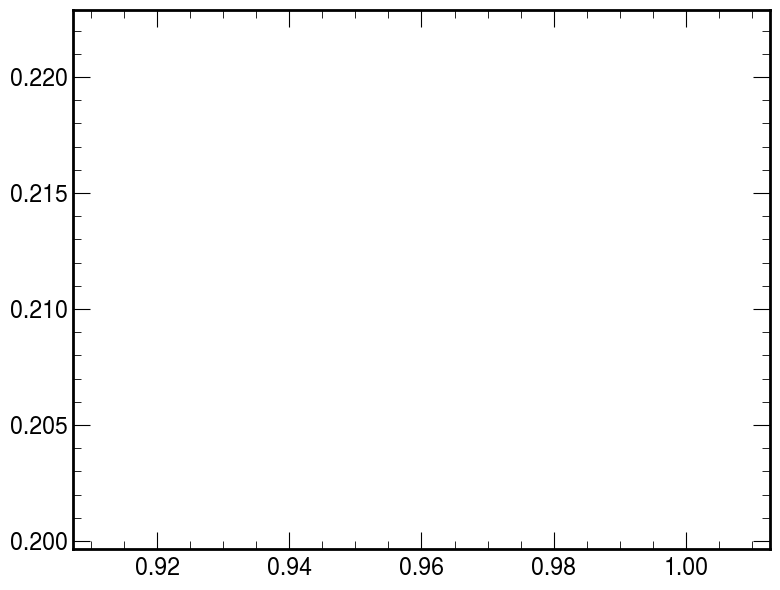

In [10]:
# with open(OUTPUT_DIRPATH + f'{CURRENT_TIME}_IN_perf.json', 'r') as f:
#     IN_perf = json.load(f)

TPR_thresholds = [0.9704, 0.9498, 0.9196, 0.7536, 0.5777, 0.3837]
print("Neural network performance")
NNtable = PrettyTable(['Threshold','Signal Efficiency','Background Contamination'])
NNtable.float_format = ".4"
for TPR_threshold in TPR_thresholds:
    thres_idx = np.argmax(np.array(IN_perf['base_tpr'])>TPR_threshold)
    NNtable.add_row(
        [
            IN_perf['mean_thresholds'][thres_idx], IN_perf['base_tpr'][thres_idx], 
            "{:.4f} +/- {:.4f}".format(IN_perf['mean_fprs'][thres_idx], IN_perf['std_fprs'][thres_idx])
        ]
    )
print(NNtable)

# plot_destdir = OUTPUT_DIRPATH + 'plots_all_samples/' + CURRENT_TIME
plot_destdir = OUTPUT_DIRPATH + 'plots_0lepton/' + CURRENT_TIME
if not os.path.exists(plot_destdir):
    os.makedirs(plot_destdir)

plot_train_val_losses(
    IN_perf, plot_destdir+'/'+CURRENT_TIME, plot_postfix='_test_data',
    labels=[str(i) for i in range(len(IN_perf['all_preds']))]
)
plot_roc(
    IN_perf, plot_destdir+'/'+CURRENT_TIME, plot_postfix='_test_data', method='arr',
    labels=[str(i) for i in range(len(IN_perf['all_preds']))], run2=False
)
print(f"num bkg: {np.sum(label_test==0)}")
print(f"num sig: {np.sum(label_test==1)}")
plot_output_score(
    IN_perf, plot_destdir+'/'+CURRENT_TIME, plot_postfix='_test_data_weighted', 
    labels=[str(i) for i in range(len(IN_perf['all_preds']))], weights={
        'bkg': data_test_aux.loc[label_test==0, "eventWeight"], 'sig': data_test_aux.loc[label_test==1, "eventWeight"]
    }, n_bins=25, 
    # all_bkg=True
)
plot_output_score(
    IN_perf, plot_destdir+'/'+CURRENT_TIME, plot_postfix='_test_data_density', 
    labels=[str(i) for i in range(len(IN_perf['all_preds']))], n_bins=25, 
    # all_bkg=True
)
s_over_root_b(
    IN_perf, plot_destdir+'/'+CURRENT_TIME, plot_postfix='_test_data', 
    labels=[str(i) for i in range(len(IN_perf['all_preds']))], weights={
        'bkg': data_test_aux.loc[label_test==0, "eventWeight"], 'sig': data_test_aux.loc[label_test==1, "eventWeight"]
    }, n_bins=25
)

for score_cut in [0.2, 0.5, 0.6, 0.7, 0.8]:
    plot_input_vars_after_score_cut(
        IN_perf, score_cut, plot_destdir, plot_prefix=CURRENT_TIME, plot_postfix='_test_data',
        # weights={
        #     'bkg': data_test_aux.loc[label_test==0, "eventWeight"], 'sig': data_test_aux.loc[label_test==1, "eventWeight"]
        # }
    )
plot_input_vars_after_score_cut(
    IN_perf, [0.2, 0.5, 0.6, 0.7, 0.8], plot_destdir, method='arr', plot_prefix=CURRENT_TIME, plot_postfix='_test_data',
    # weights={
    #     'bkg': data_test_aux.loc[label_test==0, "eventWeight"], 'sig': data_test_aux.loc[label_test==1, "eventWeight"]
    # }
)

##### Optimized cut-boundaries for ttH score output

In [10]:
def optimize_cut_boundaries(IN_perf, weights, bins=50):
    hist_list_fold = []
    cut_boundaries_fold = []
    cut_s_over_root_bs_fold = []
    sig_weights_fold = []
    bkg_weights_fold = []
    for fold_idx in range(skf.get_n_splits()):
        sig_np = np.exp(
            IN_perf['all_preds'][fold_idx]
        )[
            np.array(IN_perf['all_labels'][fold_idx]) == 1,1
        ]
        bkg_np = np.exp(
            IN_perf['all_preds'][fold_idx]
        )[
            np.array(IN_perf['all_labels'][fold_idx]) == 0,1
        ]
        hist_axis = hist.axis.Regular(bins, 0., 1., name='var', growth=False, underflow=False, overflow=False)
        sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig_np, weight=weights['sig'])
        bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg_np, weight=weights['bkg'])
        hist_list_fold.append({'sig': copy.deepcopy(sig_hist), 'bkg': copy.deepcopy(bkg_hist)})

        fold_idx_cuts_bins_inclusive = []
        fold_idx_sig_weights = []
        fold_idx_bkg_weights = []
        fold_idx_prev_s_over_root_b = []
        prev_s_over_root_b = 0
        for i in range(bins):
            s = np.sum(sig_hist.values().flatten()[
                (bins-1) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
            ])
            sqrt_b = np.sqrt(np.sum(bkg_hist.values().flatten()[
                (bins-1) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
            ]))
            if prev_s_over_root_b < (s / sqrt_b):
                prev_s_over_root_b = s / sqrt_b
                continue
            else:
                fold_idx_sig_weights.append(
                    {
                        'value': np.sum(sig_hist.values().flatten()[
                            (bins) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                        ]),
                        'w2': np.sqrt(np.sum(sig_hist.variances().flatten()[
                            (bins) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                        ])),
                    }
                )
                fold_idx_bkg_weights.append(
                    {
                        'value': np.sum(bkg_hist.values().flatten()[
                            (bins) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                        ]),
                        'w2': np.sqrt(np.sum(bkg_hist.variances().flatten()[
                            (bins) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                        ])),
                    }
                )
                fold_idx_cuts_bins_inclusive.append(bins - i)
                fold_idx_prev_s_over_root_b.append(prev_s_over_root_b)
                prev_s_over_root_b = 0
        fold_idx_sig_weights.append(
            {
                'value': np.sum(sig_hist.values().flatten()[
                    0 : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                ]),
                'w2': np.sqrt(np.sum(sig_hist.variances().flatten()[
                    0 : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                ])),
            }
        )
        fold_idx_bkg_weights.append(
            {
                'value': np.sum(bkg_hist.values().flatten()[
                    0 : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                ]),
                'w2': np.sqrt(np.sum(bkg_hist.variances().flatten()[
                    0 : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                ])),
            }
        )
        fold_idx_cuts_bins_inclusive.append(0)
        fold_idx_prev_s_over_root_b.append(prev_s_over_root_b)
        fold_idx_score_cuts = [bin_i / bins for bin_i in fold_idx_cuts_bins_inclusive]
        cut_boundaries_fold.append(fold_idx_score_cuts)
        cut_s_over_root_bs_fold.append(fold_idx_prev_s_over_root_b)
        sig_weights_fold.append(fold_idx_sig_weights)
        bkg_weights_fold.append(fold_idx_bkg_weights)
                
    sig_np = np.exp(
        IN_perf['mean_pred']
    )[
        np.array(IN_perf['mean_label']) == 1,1
    ]
    bkg_np = np.exp(
        IN_perf['mean_pred']
    )[
        np.array(IN_perf['mean_label']) == 0,1
    ]
    hist_axis = hist.axis.Regular(bins, 0., 1., name='var', growth=False, underflow=False, overflow=False)
    sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig_np, weight=weights['sig'])
    bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg_np, weight=weights['bkg'])

    cut_boundaries = []
    cut_s_over_root_bs = []
    prev_s_over_root_b = 0
    sig_weights = []
    bkg_weights = []
    for i in range(bins):
        s = np.sum(sig_hist.values().flatten()[
            (bins-1) - i : bins if len(cut_boundaries) == 0 else cut_boundaries[-1]
        ])
        sqrt_b = np.sqrt(np.sum(bkg_hist.values().flatten()[
            (bins-1) - i : bins if len(cut_boundaries) == 0 else cut_boundaries[-1]
        ]))
        if prev_s_over_root_b < (s / sqrt_b):
            prev_s_over_root_b = s / sqrt_b
            continue
        else:
            sig_weights.append(
                {
                    'value': np.sqrt(np.sum(sig_hist.values().flatten()[
                        (bins) - i : bins if len(cut_boundaries) == 0 else cut_boundaries[-1]
                    ])),
                    'w2': np.sqrt(np.sum(sig_hist.variances().flatten()[
                        (bins) - i : bins if len(cut_boundaries) == 0 else cut_boundaries[-1]
                    ])),
                }
            )
            bkg_weights.append(
                {
                    'value': np.sqrt(np.sum(bkg_hist.values().flatten()[
                        (bins) - i : bins if len(cut_boundaries) == 0 else cut_boundaries[-1]
                    ])),
                    'w2': np.sqrt(np.sum(bkg_hist.variances().flatten()[
                        (bins) - i : bins if len(cut_boundaries) == 0 else cut_boundaries[-1]
                    ])),
                }
            )
            cut_boundaries.append(bins - i)
            cut_s_over_root_bs.append(prev_s_over_root_b)
            prev_s_over_root_b = 0
    sig_weights.append(
        {
            'value': np.sum(sig_hist.values().flatten()[
                0 : bins if len(cut_boundaries) == 0 else cut_boundaries[-1]
            ]),
            'w2': np.sqrt(np.sum(sig_hist.variances().flatten()[
                0 : bins if len(cut_boundaries) == 0 else cut_boundaries[-1]
            ])),
        }
    )
    bkg_weights.append(
        {
            'value': np.sum(bkg_hist.values().flatten()[
                0 : bins if len(cut_boundaries) == 0 else cut_boundaries[-1]
            ]),
            'w2': np.sqrt(np.sum(bkg_hist.variances().flatten()[
                0 : bins if len(cut_boundaries) == 0 else cut_boundaries[-1]
            ])),
        }
    )
    cut_boundaries.append(0)
    cut_s_over_root_bs.append(prev_s_over_root_b)
    cut_boundaries = [bin_i / bins for bin_i in cut_boundaries]
    return cut_boundaries_fold, cut_s_over_root_bs_fold, sig_weights_fold, bkg_weights_fold, cut_boundaries, cut_s_over_root_bs, sig_weights, bkg_weights

In [11]:
# with open(OUTPUT_DIRPATH + f'{CURRENT_TIME}_IN_perf.json', 'r') as f:
#     IN_perf = json.load(f)

(
    cut_boundaries_fold, cut_s_over_root_bs_fold, 
    sig_weights_fold, bkg_weights_fold, 
    cut_boundaries, cut_s_over_root_bs, 
    sig_weights, bkg_weights 
) = optimize_cut_boundaries(
    IN_perf, {
        'bkg': data_test_aux.loc[label_test==0, "eventWeight"], 'sig': data_test_aux.loc[label_test==1, "eventWeight"]
    }
)

fold_labels = [
    [
        f"s/√b={cut_s_over_root_bs_fold[fold_idx][cut_idx]:.04f}, s={sig_weights_fold[fold_idx][cut_idx]['value']:.04f}±{sig_weights_fold[fold_idx][cut_idx]['w2']:.04f}, b={bkg_weights_fold[fold_idx][cut_idx]['value']:.04f}±{bkg_weights_fold[fold_idx][cut_idx]['w2']:.04f}" for cut_idx in range(len(cut_s_over_root_bs_fold[fold_idx]))
    ] for fold_idx in range(skf.get_n_splits())
]
fold_colors = [copy.deepcopy(cmap_petroff10 * ((len(cut_boundaries_fold[i]) // len(cmap_petroff10)) + 1)) for i in range(skf.get_n_splits())]
for fold_idx in range(skf.get_n_splits()):
    s_over_root_b(
        IN_perf, plot_destdir+'/'+CURRENT_TIME, plot_postfix=f'_test_data_fold{fold_idx}', 
        labels=[str(i) for i in range(len(IN_perf['all_preds']))], weights={
            'bkg': data_test_aux.loc[label_test==0, "eventWeight"], 'sig': data_test_aux.loc[label_test==1, "eventWeight"]
        }, lines_fold=cut_boundaries_fold, lines_labels=fold_labels, only_fold=fold_idx, lines_colors=fold_colors
    )
labels = [
    f"s/√b={cut_s_over_root_bs[cut_idx]:.04f}, s={sig_weights[cut_idx]['value']:.04f}±{sig_weights[cut_idx]['w2']:.04f}, b={bkg_weights[cut_idx]['value']:.04f}±{bkg_weights[cut_idx]['w2']:.04f}" for cut_idx in range(len(cut_s_over_root_bs))
]
colors = copy.deepcopy(cmap_petroff10 * ((len(cut_boundaries) // len(cmap_petroff10)) + 1))
s_over_root_b(
    IN_perf, plot_destdir+'/'+CURRENT_TIME, plot_postfix=f'_test_data_foldAvg', 
    labels=[str(i) for i in range(len(IN_perf['all_preds']))], weights={
        'bkg': data_test_aux.loc[label_test==0, "eventWeight"], 'sig': data_test_aux.loc[label_test==1, "eventWeight"]
    }, lines=cut_boundaries, lines_labels=labels, no_fold=True, lines_colors=colors
)

### Train/Val Comparison

In [12]:
IN_perf_dict = {'train': [], 'val': []}
# with open('model_outputs/v0/BestConfigReallyTopclass.json', 'r') as f:
# with open(OUTPUT_DIRPATH + CURRENT_TIME + '_BestConfigReallyTopclass.json') as f:
with open('/uscms/home/tsievert/nobackup/XHYbbgg/HHtobbyy/model_outputs/v4/extra_vars/2024-08-20_23-02-48_BestConfigReallyTopclass.json') as f:
    best_conf = json.load(f)
for fold_idx, (train_index, val_index) in enumerate(skf.split(data_hlf, label)):
    IN_perf_dict['train'].append(
        evaluate(
            data_list[train_index], data_hlf[train_index], label[train_index], 
            OUTPUT_DIRPATH, CURRENT_TIME, skf, best_conf, only_fold_idx=fold_idx,
        )
    )
    IN_perf_dict['val'].append(
        evaluate(
            data_list[val_index], data_hlf[val_index], label[val_index], 
            OUTPUT_DIRPATH, CURRENT_TIME, skf, best_conf, only_fold_idx=fold_idx,
        )
    )

with open(OUTPUT_DIRPATH + f'{CURRENT_TIME}_IN_perf_train_val.json', 'w') as f:
    json.dump(IN_perf_dict, f)


##### ROC and Output Score Dist for train/val data

In [19]:
plot_destdir = OUTPUT_DIRPATH + 'plots/' + CURRENT_TIME
if not os.path.exists(plot_destdir):
    os.makedirs(plot_destdir)
with open(OUTPUT_DIRPATH + f'{CURRENT_TIME}_IN_perf_train_val.json', 'r') as f:
    IN_perf_dict = json.load(f)

labels_arr = ['train - fold ', 'val - fold ']
val_weights_arr = []
for fold_idx, (train_IN_dict, val_IN_dict, (train_index, val_index)) in enumerate(zip(IN_perf_dict['train'], IN_perf_dict['val'], skf.split(data_hlf, label))):
    plot_roc(
        [train_IN_dict, val_IN_dict], plot_destdir+'/'+CURRENT_TIME, plot_postfix=f'_train_val_comparison_fold{fold_idx}', 
        method='IN_arr', labels=[labels_arr[0]+str(fold_idx), labels_arr[1]+str(fold_idx)]
    )
    rectified_train_index = np.ones(len(label), dtype=bool)
    rectified_train_index[val_index] = False
    sig_train_mask = rectified_train_index & (label == 1)
    sig_val_mask = np.logical_not(rectified_train_index) & (label == 1)
    bkg_train_mask = rectified_train_index & (label == 0)
    bkg_val_mask = np.logical_not(rectified_train_index) & (label == 0)
    weights = [
        {'sig': data_aux.loc[sig_train_mask, "eventWeight"], 'bkg': data_aux.loc[bkg_train_mask, "eventWeight"]},
        {'sig': data_aux.loc[sig_val_mask, "eventWeight"], 'bkg': data_aux.loc[bkg_val_mask, "eventWeight"]}
    ]
    val_weights_arr.append(copy.deepcopy(weights[1]))
    plot_output_score(
        [train_IN_dict, val_IN_dict], plot_destdir+'/'+CURRENT_TIME, plot_postfix=f'_train_val_weighted_comparison{fold_idx}', 
        method='IN_arr', labels=[labels_arr[0]+str(fold_idx), labels_arr[1]+str(fold_idx)], weights=weights
    )
    plot_output_score(
        [train_IN_dict, val_IN_dict], plot_destdir+'/'+CURRENT_TIME, plot_postfix=f'_train_val_density_comparison{fold_idx}', 
        method='IN_arr', labels=[labels_arr[0]+str(fold_idx), labels_arr[1]+str(fold_idx)], weights=[{'sig': None, 'bkg': None}]*len(labels_arr)
    )
    s_over_root_b(
        [train_IN_dict, val_IN_dict], plot_destdir+'/'+CURRENT_TIME, plot_postfix=f'_train_val_comparison{fold_idx}', 
        method='IN_arr', labels=[labels_arr[0]+str(fold_idx), labels_arr[1]+str(fold_idx)], weights=weights
    )
labels_arr = ['val - fold 0', 'val - fold 1', 'val - fold 2', 'val - fold 3', 'val - fold 4']
s_over_root_b(
    IN_perf_dict['val'], plot_destdir+'/'+CURRENT_TIME, plot_postfix=f'_val_comparison', 
    method='IN_arr', labels=labels_arr, weights=val_weights_arr
)

### Input Vars Comparison

##### pre-standardization

In [9]:
output_dir_pre_std = CURRENT_DIRPATH + f"/input_comparison{'_v2' if V2_MERGED else ''}/{VERSION}/pre_std/"
if not os.path.exists(output_dir_pre_std):
    os.makedirs(output_dir_pre_std)

pre_std_hists = {}
label_arr = [
    MC_NAMES_PRETTY["GluGluToHH"]+" train", MC_NAMES_PRETTY["GluGluToHH"]+" test",
    MC_NAMES_PRETTY["ttHToGG"]+" train", MC_NAMES_PRETTY["ttHToGG"]+" test"
]
label_arr_fold = [
    MC_NAMES_PRETTY["GluGluToHH"]+" train", MC_NAMES_PRETTY["GluGluToHH"]+" val", MC_NAMES_PRETTY["GluGluToHH"]+" test",
    MC_NAMES_PRETTY["ttHToGG"]+" train", MC_NAMES_PRETTY["ttHToGG"]+" val", MC_NAMES_PRETTY["ttHToGG"]+" test"
]
for var_name in high_level_fields:
    if var_name in {'event', 'puppiMET_eta'}:
        continue
    sig_mask = (label == 1)
    sig_test_mask = (label_test == 1)
    bkg_mask = (label == 0)
    bkg_test_mask = (label_test == 0)
    for fold_idx, (train_index, val_index) in enumerate(skf.split(data_hlf, label)):
        rectified_train_index = np.ones(len(label), dtype=bool)
        rectified_train_index[val_index] = False
        
        sig_train_mask = rectified_train_index & sig_mask
        sig_val_mask = np.logical_not(rectified_train_index) & sig_mask
        bkg_train_mask = rectified_train_index & bkg_mask
        bkg_val_mask = np.logical_not(rectified_train_index) & bkg_mask

        sig_train_np = data_df.loc[sig_train_mask, var_name].to_numpy()
        sig_val_np = data_df.loc[sig_val_mask, var_name].to_numpy()
        sig_test_np = data_test_df.loc[sig_test_mask, var_name].to_numpy()
        bkg_train_np = data_df.loc[bkg_train_mask, var_name].to_numpy()
        bkg_val_np = data_df.loc[bkg_val_mask, var_name].to_numpy()
        bkg_test_np = data_test_df.loc[bkg_test_mask, var_name].to_numpy()

        sig_train_hist = hist.Hist(VARIABLES[var_name]).fill(var=sig_train_np[sig_train_np != 0])
        sig_val_hist = hist.Hist(VARIABLES[var_name]).fill(var=sig_val_np[sig_val_np != 0])
        sig_test_hist = hist.Hist(VARIABLES[var_name]).fill(var=sig_test_np[sig_test_np != 0])
        bkg_train_hist = hist.Hist(VARIABLES[var_name]).fill(var=bkg_train_np[bkg_train_np != 0])
        bkg_val_hist = hist.Hist(VARIABLES[var_name]).fill(var=bkg_val_np[bkg_val_np != 0])
        bkg_test_hist = hist.Hist(VARIABLES[var_name]).fill(var=bkg_test_np[bkg_test_np != 0])

        make_input_plot(
            output_dir_pre_std, var_name, 
            [sig_train_hist, sig_val_hist, sig_test_hist, bkg_train_hist, bkg_val_hist, bkg_test_hist], 
            fold_idx=fold_idx, labels=label_arr_fold
        )
    sig_train_np = data_df.loc[sig_mask, var_name].to_numpy()
    sig_test_np = data_test_df.loc[sig_test_mask, var_name].to_numpy()
    bkg_train_np = data_df.loc[bkg_mask, var_name].to_numpy()
    bkg_test_np = data_test_df.loc[bkg_test_mask, var_name].to_numpy()
    sig_train_hist = hist.Hist(VARIABLES[var_name]).fill(var=sig_train_np[sig_train_np != 0])
    sig_test_hist = hist.Hist(VARIABLES[var_name]).fill(var=sig_test_np[sig_test_np != 0])
    bkg_train_hist = hist.Hist(VARIABLES[var_name]).fill(var=bkg_train_np[bkg_train_np != 0])
    bkg_test_hist = hist.Hist(VARIABLES[var_name]).fill(var=bkg_test_np[bkg_test_np != 0])
    pre_std_hists[var_name] = [
        copy.deepcopy(sig_train_hist), copy.deepcopy(sig_test_hist), 
        copy.deepcopy(bkg_train_hist), copy.deepcopy(bkg_test_hist)
    ]
    make_input_plot(output_dir_pre_std, var_name, pre_std_hists[var_name], labels=label_arr)

##### post-standardization

In [57]:
output_dir_post_std = CURRENT_DIRPATH + f"/input_comparison{'_v2' if V2_MERGED else ''}/{VERSION}/post_std/"
if not os.path.exists(output_dir_post_std):
    os.makedirs(output_dir_post_std)

post_std_hists = {}
label_arr = [
    MC_NAMES_PRETTY["GluGluToHH"]+" train", MC_NAMES_PRETTY["GluGluToHH"]+" test",
    MC_NAMES_PRETTY["ttHToGG"]+" train", MC_NAMES_PRETTY["ttHToGG"]+" test"
]
label_arr_fold = [
    MC_NAMES_PRETTY["GluGluToHH"]+" train", MC_NAMES_PRETTY["GluGluToHH"]+" val", MC_NAMES_PRETTY["GluGluToHH"]+" test",
    MC_NAMES_PRETTY["ttHToGG"]+" train", MC_NAMES_PRETTY["ttHToGG"]+" val", MC_NAMES_PRETTY["ttHToGG"]+" test"
]
for var_name in high_level_fields:
    if var_name in {'event', 'puppiMET_eta'}:
        continue
    data, data_test = None, None
    if var_name in (high_level_fields - set(input_hlf_vars)):
        data, data_test = data_list, data_list_test
    else:
        data, data_test = data_hlf, data_hlf_test
    for fold_idx, (train_index, val_index) in enumerate(skf.split(data_hlf, label)):
        rectified_train_index = np.ones(len(label), dtype=bool)
        rectified_train_index[val_index] = False
        (
            sig_train_np, sig_val_np, sig_test_np, 
            bkg_train_np, bkg_val_np, bkg_test_np 
        ) = post_std_np_arrays(
            data, data_test, var_name,
            train_index=rectified_train_index, val_index=np.logical_not(rectified_train_index)
        )
        sig_train_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=sig_train_np[sig_train_np != 0])
        sig_val_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=sig_val_np[sig_val_np != 0])
        sig_test_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=sig_test_np[sig_test_np != 0])
        bkg_train_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=bkg_train_np[bkg_train_np != 0])
        bkg_val_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=bkg_val_np[bkg_val_np != 0])
        bkg_test_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=bkg_test_np[bkg_test_np != 0])

        make_input_plot(
            output_dir_post_std, var_name, 
            [sig_train_hist, sig_val_hist, sig_test_hist, bkg_train_hist, bkg_val_hist, bkg_test_hist], 
            fold_idx=fold_idx, labels=label_arr_fold
        )
    sig_train_np, sig_test_np, bkg_train_np, bkg_test_np = post_std_np_arrays(data, data_test, var_name)

    sig_train_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=sig_train_np[sig_train_np != 0])
    sig_test_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=sig_test_np[sig_test_np != 0])
    bkg_train_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=bkg_train_np[bkg_train_np != 0])
    bkg_test_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=bkg_test_np[bkg_test_np != 0])
    post_std_hists[var_name] = [
        copy.deepcopy(sig_train_hist), copy.deepcopy(sig_test_hist), 
        copy.deepcopy(bkg_train_hist), copy.deepcopy(bkg_test_hist)
    ]
    make_input_plot(output_dir_post_std, var_name, post_std_hists[var_name], labels=label_arr)
    

### Gaussian smearing on test set (for feature importance)

##### Functions to smear variables

In [19]:
def smear_particle_list(var_name, particle_list_to_smear, method='multiply', seed=SEED):
    mask_arr = data_list_index_map(var_name, particle_list_to_smear, np.ones(len(particle_list_to_smear), dtype=bool))

    # Performs the smearing and returns the result
    rng = np.random.default_rng(seed=seed)
    if method == 'multiply':
        particle_list_to_smear[mask_arr] *= rng.normal(size=len(particle_list_to_smear))
    elif method == 'add':
        particle_list_to_smear[mask_arr] += rng.normal(size=len(particle_list_to_smear))
    else:
        raise Exception(f"Only 'multiply' and 'add' are allowed as methods. You passed {method}.")

    return particle_list_to_smear


def smear_particle_hlf(var_name, particle_hlf_to_smear, method='multiply', seed=SEED):
    index2 = hlf_vars_columns[var_name]
    rng = np.random.default_rng(seed=seed)
    if method == 'multiply':
        particle_hlf_to_smear[:, index2] *= rng.normal(size=len(particle_hlf_to_smear))
    elif method == 'add':
        particle_hlf_to_smear[:, index2] += rng.normal(size=len(particle_hlf_to_smear))
    else:
        raise Exception(f"Only 'multiply' and 'add' are allowed as methods. You passed {method}.")
    
    return particle_hlf_to_smear

##### Evaluate smeared variable test-data on the model

In [20]:
IN_perf_smear_dict = {}
# with open('model_outputs/v0/BestConfigReallyTopclass.json', 'r') as f:
# with open(OUTPUT_DIRPATH + CURRENT_TIME + '_BestConfigReallyTopclass.json') as f:
with open('/uscms/home/tsievert/nobackup/XHYbbgg/HHtobbyy/model_outputs/v4/extra_vars/2024-08-20_23-02-48_BestConfigReallyTopclass.json') as f:
    best_conf = json.load(f)
for var_name in high_level_fields:
    if var_name in {'event', 'eventWeight'}:
        continue
    gauss_data_list, gauss_data_hlf = None, None
    if var_name in (high_level_fields - set(input_hlf_vars)):
        gauss_data_list = smear_particle_list(var_name, copy.deepcopy(data_list_test))
        gauss_data_hlf = data_hlf_test
    else:
        gauss_data_list = data_list_test
        gauss_data_hlf = smear_particle_hlf(var_name, copy.deepcopy(data_hlf_test))

    IN_perf_smear_dict[var_name] = evaluate(
        gauss_data_list, gauss_data_hlf, label_test, OUTPUT_DIRPATH, CURRENT_TIME, skf, best_conf,
    )

with open(OUTPUT_DIRPATH + f'{CURRENT_TIME}_IN_perf_gauss_smear.json', 'w') as f:
    json.dump(IN_perf_smear_dict, f)

##### ROC for gaussian smear variables

In [26]:
plot_destdir = OUTPUT_DIRPATH + 'plots/' + CURRENT_TIME
if not os.path.exists(plot_destdir):
    os.makedirs(plot_destdir)
with open(OUTPUT_DIRPATH + f'{CURRENT_TIME}_IN_perf_gauss_smear.json', 'r') as f:
    IN_perf_smear_dict = json.load(f)
IN_perf_smear_list = []
label_arr = []
for var_name, IN_perf_smear in IN_perf_smear_dict.items():
    IN_perf_smear_list.append(IN_perf_smear)
    label_arr.append(var_name)
sort = np.argsort([IN_perf_smear['mean_area'] for IN_perf_smear in IN_perf_smear_list])
plot_roc(
    list(IN_perf_smear_dict.values()), plot_destdir+'/'+CURRENT_TIME, plot_postfix='_gauss_smear_all', 
    method='IN_arr', labels=label_arr, yscale='log', run2=False, sort=sort
)
plot_roc(
    [list(IN_perf_smear_dict.values())[i] for i in sort[:5]], plot_destdir+'/'+CURRENT_TIME, plot_postfix='_gauss_smear_top5', 
    method='IN_arr', labels=[label_arr[i] for i in sort[:5]], yscale='log', run2=False
)
with open(OUTPUT_DIRPATH + f'{CURRENT_TIME}_IN_perf.json', 'r') as f:
    IN_perf = json.load(f)
plot_roc(
    [list(IN_perf_smear_dict.values())[i] for i in sort[:5]], plot_destdir+'/'+CURRENT_TIME, plot_postfix='_gauss_smear_top5_and_orig', 
    method='IN_arr', labels=[label_arr[i] for i in sort[:5]], yscale='log', run2=False, run3=IN_perf
)

##### Gaussian Smeared input Vars

In [23]:
output_dir_gauss_smear = CURRENT_DIRPATH + f"/input_comparison{'_v2' if V2_MERGED else ''}/{VERSION}/gauss_smear/"
if not os.path.exists(output_dir_gauss_smear):
    os.makedirs(output_dir_gauss_smear)

gauss_hists = {}
label_arr = [
    MC_NAMES_PRETTY["GluGluToHH"]+" train", MC_NAMES_PRETTY["GluGluToHH"]+" test",
    MC_NAMES_PRETTY["ttHToGG"]+" train", MC_NAMES_PRETTY["ttHToGG"]+" test"
]
label_arr_fold = [
    MC_NAMES_PRETTY["GluGluToHH"]+" train", MC_NAMES_PRETTY["GluGluToHH"]+" val", MC_NAMES_PRETTY["GluGluToHH"]+" test",
    MC_NAMES_PRETTY["ttHToGG"]+" train", MC_NAMES_PRETTY["ttHToGG"]+" val", MC_NAMES_PRETTY["ttHToGG"]+" test"
]
for var_name in high_level_fields:
    if var_name in {'event', 'puppiMET_eta'}:
        continue
    data, data_test = None, None
    if var_name in (high_level_fields - set(input_hlf_vars)):
        data, data_test = smear_particle_list(var_name, data_list), smear_particle_list(var_name, data_list_test)
    else:
        data, data_test = smear_particle_hlf(var_name, data_hlf), smear_particle_hlf(var_name, data_hlf_test)
    for fold_idx, (train_index, val_index) in enumerate(skf.split(data_hlf, label)):
        rectified_train_index = np.ones(len(label), dtype=bool)
        rectified_train_index[val_index] = False
        (
            sig_train_np, sig_val_np, sig_test_np, 
            bkg_train_np, bkg_val_np, bkg_test_np 
        ) = post_std_np_arrays(
            data, data_test, var_name, 
            train_index=rectified_train_index, val_index=np.logical_not(rectified_train_index)
        )
        sig_train_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=sig_train_np[sig_train_np != 0])
        sig_val_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=sig_val_np[sig_val_np != 0])
        sig_test_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=sig_test_np[sig_test_np != 0])
        bkg_train_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=bkg_train_np[bkg_train_np != 0])
        bkg_val_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=bkg_val_np[bkg_val_np != 0])
        bkg_test_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=bkg_test_np[bkg_test_np != 0])

        make_input_plot(
            output_dir_gauss_smear, var_name, 
            [sig_train_hist, sig_val_hist, sig_test_hist, bkg_train_hist, bkg_val_hist, bkg_test_hist], 
            fold_idx=fold_idx, labels=label_arr_fold
        )
    sig_train_np, sig_test_np, bkg_train_np, bkg_test_np = post_std_np_arrays(data, data_test, var_name)

    sig_train_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=sig_train_np[sig_train_np != 0])
    sig_test_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=sig_test_np[sig_test_np != 0])
    bkg_train_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=bkg_train_np[bkg_train_np != 0])
    bkg_test_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=bkg_test_np[bkg_test_np != 0])
    gauss_hists[var_name] = [
        copy.deepcopy(sig_train_hist), copy.deepcopy(sig_test_hist), 
        copy.deepcopy(bkg_train_hist), copy.deepcopy(bkg_test_hist)
    ]
    make_input_plot(output_dir_gauss_smear, var_name, gauss_hists[var_name], labels=label_arr)

### Mass sculpting

In [12]:
# with open('model_outputs/v0/BestConfigReallyTopclass.json', 'r') as f:
# with open(OUTPUT_DIRPATH + CURRENT_TIME + '_BestConfigReallyTopclass.json') as f:
with open('/uscms/home/tsievert/nobackup/XHYbbgg/HHtobbyy/model_outputs/v4/extra_vars/2024-08-20_23-02-48_BestConfigReallyTopclass.json') as f:
    best_conf = json.load(f)
IN_full_eval_dict = {}
for data_type, p_list, hlf, y in [('train', data_list, data_hlf, label), ('test', data_list_test, data_hlf_test, label_test)]:
    IN_full_eval_dict[data_type] = evaluate(
        p_list, hlf, y, 
        OUTPUT_DIRPATH, CURRENT_TIME, skf, best_conf,
    )

with open(OUTPUT_DIRPATH + f'{CURRENT_TIME}_IN_perf_full_eval.json', 'w') as f:
    json.dump(IN_full_eval_dict, f)

##### Mass dists with successive score cuts

In [13]:
plot_destdir = OUTPUT_DIRPATH + 'plots/' + CURRENT_TIME
if not os.path.exists(plot_destdir):
    os.makedirs(plot_destdir)
with open(OUTPUT_DIRPATH + f'{CURRENT_TIME}_IN_perf_full_eval.json', 'r') as f:
    IN_full_eval_dict = json.load(f)

score_cuts = [0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.99]
label_arr = [
    MC_NAMES_PRETTY["GluGluToHH"]+" train, score cut = ", MC_NAMES_PRETTY["GluGluToHH"]+" test, score cut = ",
    MC_NAMES_PRETTY["ttHToGG"]+" train, score cut = ", MC_NAMES_PRETTY["ttHToGG"]+" test, score cut = "
] * len(score_cuts)
label_arr = [label_arr[label_idx]+str(score_cuts[score_idx // (len(label_arr)//len(score_cuts))]) for score_idx, label_idx in enumerate(range(len(label_arr)))]
hist_dict = {'mass': [], 'dijet_mass': []}
for var_name in hist_dict.keys():
    for i, score_cut in enumerate(score_cuts):
        sig_train_np, sig_test_np, bkg_train_np, bkg_test_np = aux_np_arrays(var_name, score_cut, IN_full_eval_dict)
        sig_train_hist = hist.Hist(VARIABLES[var_name]).fill(var=sig_train_np)
        sig_test_hist = hist.Hist(VARIABLES[var_name]).fill(var=sig_test_np)
        bkg_train_hist = hist.Hist(VARIABLES[var_name]).fill(var=bkg_train_np)
        bkg_test_hist = hist.Hist(VARIABLES[var_name]).fill(var=bkg_test_np)
        hist_dict[var_name].extend(
            [
                copy.deepcopy(sig_train_hist), copy.deepcopy(sig_test_hist), 
                copy.deepcopy(bkg_train_hist), copy.deepcopy(bkg_test_hist)
            ]
        )
    for mod_factor, label_mod in enumerate(['sig_train', 'sig_test', 'bkg_train', 'bkg_test']):
        plot_list = []
        label_list = []
        for i in range(len(hist_dict[var_name])):
            if (i - mod_factor) % 4 == 0:
                plot_list.append(hist_dict[var_name][i])
                label_list.append(label_arr[i])
        make_input_plot(
            plot_destdir, var_name, plot_list, labels=label_list, density=True, 
            plot_prefix=CURRENT_TIME+'_', plot_postfix='_'+label_mod, alpha=0.5,
            linestyle=False
        )

### Train dataset size plot

In [ ]:
train_size_dirs = glob.glob(OUTPUT_DIRPATH[:-1]+'_mod*') + [OUTPUT_DIRPATH[:-1]]
final_train_losses_arr, final_val_losses_arr = [], []
mod_values_arr = []

for train_size_dir in train_size_dirs:
    if len(glob.glob(train_size_dir + '/*IN_perf.json')) == 0:
        continue
    try:
        mod_values_arr.append([
            float(
                train_size_dir[
                    train_size_dir.find('_mod')+4 : train_size_dir.find('-')
                ]
            ),
            float(
                train_size_dir[train_size_dir.find('-')+1:]
            )
        ])
    except:
         mod_values_arr.append([2, 2])
    IN_perf_path = glob.glob(f'{train_size_dir}/*IN_perf.json')[0]
    with open(IN_perf_path, 'r') as f:
        IN_perf = json.load(f)
    final_train_losses_arr.append([train_losses[-7 if len(train_losses) < NUM_EPOCHS else -1] for train_losses in IN_perf['train_losses_arr']])
    final_val_losses_arr.append([val_losses[-7 if len(val_losses) < NUM_EPOCHS else -1] for val_losses in IN_perf['val_losses_arr']])

final_train_losses_arr = np.array(final_train_losses_arr)
final_val_losses_arr = np.array(final_val_losses_arr)
mod_values_arr = np.array(mod_values_arr)
dataset_sizes = (len(label) + len(label_test)) / mod_values_arr
sorted_indices = np.argsort(dataset_sizes[:, 0])

plot_destdir = OUTPUT_DIRPATH + 'plots/' + CURRENT_TIME
if not os.path.exists(plot_destdir):
    os.makedirs(plot_destdir)

plt.plot(
    dataset_sizes[:, 0][sorted_indices], np.mean(final_train_losses_arr, axis=1)[sorted_indices], color='k'
)
plt.fill_between(
    dataset_sizes[:, 0][sorted_indices], (np.mean(final_train_losses_arr, axis=1)-np.std(final_train_losses_arr, axis=1))[sorted_indices], 
    (np.mean(final_train_losses_arr, axis=1)+np.std(final_train_losses_arr, axis=1))[sorted_indices], 
    color=cmap_petroff10[0], alpha=0.5, label='Train data'
)
plt.plot(
    dataset_sizes[:, 0][sorted_indices], np.mean(final_val_losses_arr, axis=1)[sorted_indices], color='k'
)
plt.fill_between(
    dataset_sizes[:, 0][sorted_indices], (np.mean(final_val_losses_arr, axis=1)-np.std(final_val_losses_arr, axis=1))[sorted_indices], 
    (np.mean(final_val_losses_arr, axis=1)+np.std(final_val_losses_arr, axis=1))[sorted_indices], 
    color=cmap_petroff10[1], alpha=0.5, label='Val data'
)
plt.xlabel('Size of train dataset')
plt.ylabel('Loss')
plt.legend()
plt.savefig(plot_destdir + '/train_val_comparison_varying_trainset_size.pdf')
plt.savefig(plot_destdir + '/train_val_comparison_varying_trainset_size.png')
plt.close()